In [21]:
%matplotlib inline
import msprime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import SVG


In [73]:
population_configurations = [
    msprime.PopulationConfiguration(sample_size=2),
    msprime.PopulationConfiguration(sample_size=2)]
theta = 2
rho = 1

def run_simulation(m, num_replicates=1):
    migration_matrix = [[0, m], [m, 0]]
    replicates = msprime.simulate(
        population_configurations=population_configurations,
        migration_matrix=migration_matrix,
        num_replicates=num_replicates, 
        mutation_rate=theta / 4,
        recombination_rate=rho / 4)
    data = np.zeros((num_replicates, 3, 3))
    for rep_index, ts in enumerate(replicates):
        for tree in ts.trees(tracked_samples=[0, 1]):            
            for site in tree.sites():
                for mutation in site.mutations:                    
                    nleaves0 = tree.num_tracked_samples(mutation.node)
                    nleaves1 = tree.num_samples(mutation.node) - nleaves0                
                    data[rep_index, nleaves0, nleaves1] += 1            
    return data       

true_m = 0.3
truth = run_simulation(true_m, num_replicates=20)
truth_mean = np.mean(truth, axis=0)
print("truth =")
print(truth_mean)


truth =
[[ 0.    3.35  0.75]
 [ 2.55  1.05  0.75]
 [ 0.55  0.8   0.  ]]


In [74]:
num_replicates = 1000
prior_m = np.random.exponential(0.1, num_replicates)
#prior_m = np.random.uniform(0, 5, size=num_replicates)
distance = np.zeros(num_replicates)
for j in range(num_replicates):
    data = run_simulation(prior_m[j], num_replicates=20)
    data_mean = np.mean(data, axis=0)
    # Compute the Euclidean distance
    distance[j] = np.sqrt(np.sum((data_mean - truth_mean)**2))   


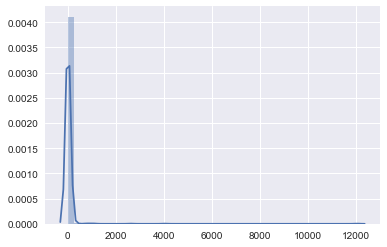

In [75]:
sns.distplot(distance)

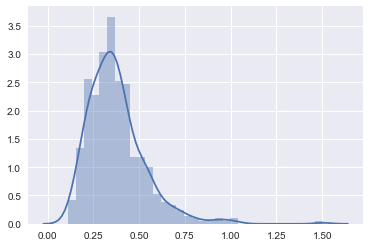

In [76]:
cutoff = np.percentile(distance, 50)
keep = np.where(distance < cutoff)

weighted_prior = prior_m[keep] * distance[keep]

sns.distplot(weighted_prior)

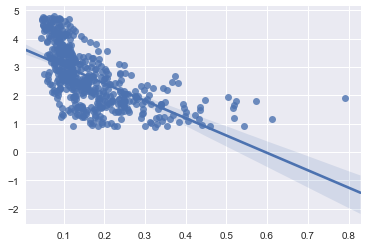

In [77]:
sns.regplot(prior_m[keep], distance[keep])